In [26]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import measure
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import scipy
import sparse

%matplotlib inline

In [27]:
def show_slices(slices, cmap="gray"):
    # This function comes from the nibabel
    # tutorial --> https://nipy.org/nibabel/coordinate_systems.html#introducing-someone
    
    fig, axes = plt.subplots(1, len(slices))

    for i, slice in enumerate(slices):
        im = axes[i].imshow(slice.T, cmap=cmap, origin="lower")
        
    plt.show()

In [28]:
def contour_slices(slices, cmap="gray", total_levels=6):
    # This function includes also plotting contour plot
    # link --> https://www.python-course.eu/matplotlib_contour_plot.php
    # link --> https://github.com/silx-kit/silx/issues/2242
    
    fig, axes = plt.subplots(1, len(slices), figsize=(5,5))
    contour_levels = total_levels
    titles = ['sagital', 'coronal', 'axial']
    
    for i, slice in enumerate(slices):
        row, col = np.shape(slice)
        y = np.arange(0, row)
        x = np.arange(0, col)
        xx, yy = np.meshgrid(x, y)

        
        zzmin, zzmax = np.min(slice), np.max(slice)
        levels = np.linspace(zzmin, zzmax, contour_levels)

        #Display image with contour plot
        im = axes[i].imshow(slice.T, cmap=cmap, origin="lower")
        contour = axes[i].contour(yy, xx, slice, levels)
        axes[i].clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
        c = ('#ff0000', '#ffff00', '#0000FF', '0.6', 'c', 'm')
        contour_filled = axes[i].contourf(yy, xx, slice, colors=c)

        
    plt.show()

In [29]:
print(os.getenv("MICCAI_DIR"))

/home/storm/31_GB_volume_1


In [30]:
# Path to the dataset and lesions

dir_dataset = os.path.join("/home/storm/31_GB_volume_1", 
                          "MICCAI_2016/Preprocessed/010_01")

lesion_path = os.path.join(dir_dataset, 'lesion_registered.nii.gz')
flair_path = os.path.join(dir_dataset, 'FLAIR_preprocessed.nii.gz')
gado_path = os.path.join(dir_dataset, 'GADO_preprocessed.nii.gz')

# Loading images
lesion = nib.load(lesion_path).get_fdata()
flair = nib.load(flair_path).get_fdata()
gado = nib.load(gado_path).get_fdata()

#Normalization
norm_f = np.linalg.norm(flair)
norm_g = np.linalg.norm(gado)

flair /= norm_f
gado /= norm_g

In [31]:
dir_dataset

'/home/storm/31_GB_volume_1/MICCAI_2016/Preprocessed/010_01'

(144, 512, 512)


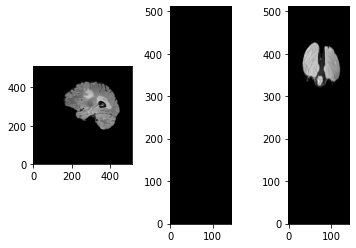

In [32]:
print(flair.shape)
slice_0 = flair[100, :, :]
slice_1 = flair[:,100,:]
slice_2 = flair[:, :, 200]
show_slices([slice_0, slice_1, slice_2])

(144, 512, 512)


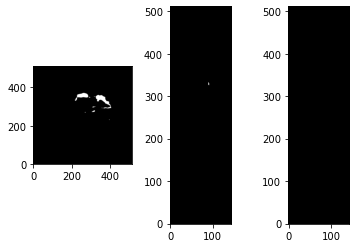

In [33]:
print(flair.shape)
slice_0 = lesion[50, :, :]
slice_1 = lesion[:,200,:]
slice_2 = lesion[:, :, 100]
show_slices([slice_0, slice_1, slice_2])

In [34]:
import pandas as pd 
# Calculate the different lesion volumes
# https://forum.image.sc/t/extract-3d-measurements-volume-centroid-etc-from-masked-stack/43444
from skimage import data, util, measure, morphology

mask = lesion > 0
#We clean the lesion volume of a very small lesions
mask = morphology.remove_small_objects(mask, min_size=30) 
label_image = measure.label(mask, connectivity=lesion.ndim)

#
props = measure.regionprops(label_image)
properties = ['label', 'area', 'centroid']
props_table = measure.regionprops_table(label_image,
                           properties=properties)

data = pd.DataFrame(props_table)  

In [35]:
print(data)

    label    area  centroid-0  centroid-1  centroid-2
0       1     139   24.712230  302.338129  358.956835
1       2     221   30.746606  287.384615  343.923077
2       3  170180   73.636649  308.608373  340.681196
3       4      82   38.390244  301.317073  356.158537
4       5      38   40.342105  223.421053  333.842105
5       6      41   46.780488  354.780488  231.341463
6       7     246   50.256098  313.747967  272.398374
7       8      33   51.212121  392.636364  228.606061
8       9    2847   60.185810  349.297155  237.889708
9      10     420   62.428571  266.778571  407.745238
10     11     109   62.816514  362.477064  249.733945
11     12     982   65.865580  314.008147  254.269857
12     13      51   67.294118  320.176471  274.568627
13     14      80   70.537500  338.062500  265.625000
14     15      30   68.733333  363.233333  252.533333
15     16     132   75.348485  322.143939  268.196970
16     17    2656   86.187877  347.973268  243.739834
17     18     248   81.35483

In [36]:
from scipy.ndimage.morphology import distance_transform_edt 
# Source --> https://stackoverflow.com/questions/44770396/how-does-the-scipy-distance-transform-edt-function-work
# Lesions need to be treated separately
# Perfect dist func is of the form: --> exp(-(1 / (10 - x) (10 - x))) * exp(- 1 / (x *x))
dict_dist = {}
total_components = 10
total_harms = [comp for comp in range(total_components)]

def TestFun(samples):
  
    t_vals = np.linspace(-4, 20, num=samples)
    t_vals [t_vals==0] = 1.0e-6
    
    # This should work for all values:
    f = np.exp(-1/(t_vals**2))
    
    # Eliminate the zero and negative values:
    f [t_vals<=0] = 0
    return f

for ind in np.nditer(props_table['label']):
    region = label_image==ind
    res = np.where(region == True)

    # Need to crop the image
    s_min = min(res[0])
    s_max = max(res[0])
    x_min = min(res[1])
    x_max = max(res[1])
    y_min = min(res[2])
    y_max = max(res[2])

    # 03/15/22 We need to use sparse arrays
    cropped_brain = region[s_min:s_max, x_min:x_max, y_min:y_max]
    cropped_flair = flair[s_min:s_max, x_min:x_max, y_min:y_max]
    cropped_gado = gado[s_min:s_max, x_min:x_max, y_min:y_max]
    edt, inds = distance_transform_edt(cropped_brain!=0, return_indices=True) 
    
    d_max = np.max(edt)
    
    edt = np.exp(-(1 / (10 - edt) * (10 - edt))) * np.exp(-1 / (edt**2))
    #Adding to the dictionary
    dict_dist[int(ind)] = {}
    dict_dist[int(ind)]["harmonics"] = {}
    dict_dist[int(ind)]["edt"] = edt
    dict_dist[int(ind)]["max_dist"] = d_max
    dict_dist[int(ind)]["flair"] = cropped_flair
    dict_dist[int(ind)]["gado"] = cropped_gado
    dict_dist[int(ind)]["gt"] = cropped_brain
    
    dict_dist[int(ind)]["harmonics"]["list"] = []
    #total_amfm = 0
    for count, harm in enumerate(total_harms):  
        amp = edt > 0
        amp = amp.astype(int)
        
        #if count % 2==0:
        amfm = amp * np.cos(harm *(edt / d_max)*2*np.pi) 
        #else:
        #amfm = amp * np.sin((harm)*(edt / d_max)*2*np.pi) 
        #total_amfm += amfm
        #dict_dist[int(ind)]["harmonics"][harm] = amfm
        dict_dist[int(ind)]["harmonics"]["list"].append(amfm)
            
    total_list = dict_dist[int(ind)]["harmonics"]["list"]
    array_basis = np.array([comp.flatten() for comp in total_list])
    array_basis = np.transpose(array_basis)
    
    #Build a test function:
    x, y = array_basis.shape
    TestFunx = TestFun(x)
    TestFuny = TestFun(y)
    
    TestFun_tot = np.outer(TestFunx, TestFuny)
    
    array_basis *= TestFun_tot
    
    # Normalization
    #norm_g = np.linalg.norm(gado)
    #flair /= norm_f
    
    
    dict_dist[int(ind)]["harmonics"]["array"] = array_basis
    
    

/home/storm/anaconda3/envs/pytorch_cpu/lib/python3.7/site-packages/ipykernel_launcher.py:41: RuntimeWarning: divide by zero encountered in true_divide


In [37]:
# Example of array basis
basis = dict_dist[12]["harmonics"]["array"]

# Applying SVD
u, s, vh = scipy.linalg.svd(basis)
rank = np.linalg.matrix_rank(basis)
row, col = np.shape(basis)
v_null = vh[:, rank:]
u_left_null = u[:, rank:]



In [38]:
from scipy.linalg import lstsq

les = 12
array_basis = dict_dist[les]["harmonics"]["array"] 
dc = dict_dist[les]["harmonics"]["list"][0]
c_1 = dict_dist[les]["harmonics"]["list"][1]
lesion_flair = dict_dist[les]["flair"]
lesion_gado = dict_dist[les]["gado"]
edt = dict_dist[les]["edt"]
gt = dict_dist[les]["gt"]


sl, x, y = lesion_flair.shape

#u, s, vh = np.linalg.svd(array_basis)
inv_basis = np.linalg.pinv(array_basis)

b = lesion_flair.flatten()
b = np.reshape(b, (-1, 1))

b_gado = lesion_gado.flatten()
b_gado = np.reshape(b_gado, (-1, 1))
#
p, res, rnk, s = lstsq(array_basis, b)
p_gado, res_gado, rnk_gado, s_gado = lstsq(array_basis, b_gado)
#
tmp = array_basis @ p
recon_flair = tmp.reshape((sl, x, y))

tmp = array_basis @ p_gado
recon_gado = tmp.reshape((sl, x, y))



# Saving matrices
np.save("Matrix_A.npy", array_basis)
np.save("Flair_lesion.npy", lesion_flair)


(2457, 2457)


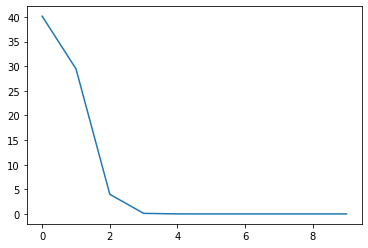

In [39]:
plt.plot(s)
print(u.shape)

In [40]:
projected_b = u_left_null @ np.matrix(u_left_null).getH() @ b

In [41]:
print(projected_b.shape)
print(lesion_flair.shape)
print(sl)
projected_b = np.array(projected_b)
projected_b = projected_b.ravel().reshape((sl, x, y))

(2457, 1)
(7, 27, 13)
7


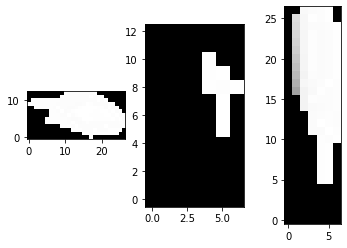

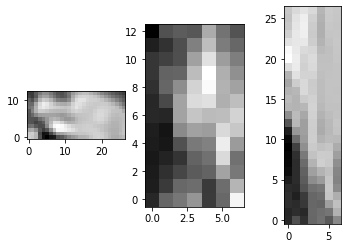

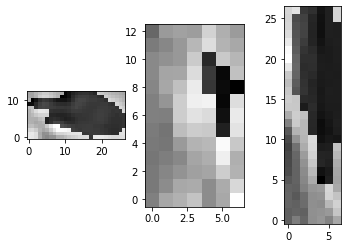

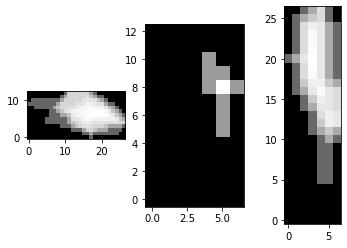

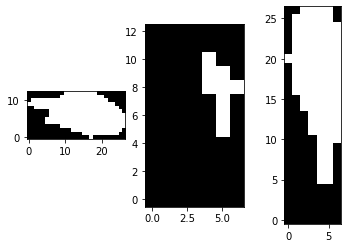

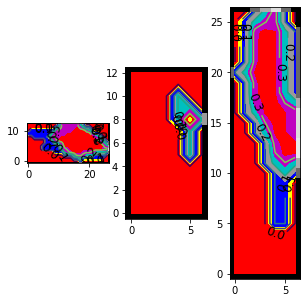

In [42]:
harm = recon_flair
sl_= 4
sx_ = 4
sy_ = 4
tot_b = edt + projected_b

slice_0 = harm[sl_, :, :]
slice_1 = harm[:,sx_,:]
slice_2 = harm[:, :, sy_]

flair_0 = lesion_flair[sl_, :, :]
flair_1 = lesion_flair[:,sx_,:]
flair_2 = lesion_flair[:, :, sy_] 

edt_0 = edt[sl_, :, :]
edt_1 = edt[:,sx_,:]
edt_2 = edt[:, :, sy_]

gt_0 = gt[sl_, :, :]
gt_1 = gt[:,sx_,:]
gt_2 = gt[:, :, sy_]

dc_0 = dc[sl_, :, :]
dc_1 = dc[:,sx_,:]
dc_2 = dc[:, :, sy_]

c_0 = c_1[sl_, :, :]
c_11 = c_1[:,sx_,:]
c_2 = c_1[:, :, sy_]

proj_b_0 = projected_b[sl_, :, :]
proj_b_1 = projected_b[:, sl_, :]
proj_b_2 = projected_b[:, :, sl_]

tot_b_0 = tot_b[sl_, :, :]
tot_b_1 = tot_b[:, sl_, :]
tot_b_2 = tot_b[:, :, sl_]


'''
slice_0 = lesion_gado[4, :, :]
slice_1 = lesion_gado[:,6,:]
slice_2 = lesion_gado[:, :, 11]

gado_0 = recon_gado[4, :, :]
gado_1 = recon_gado[:,6,:]
gado_2 = recon_gado[:, :, 11]
'''
show_slices([slice_0, slice_1, slice_2], 'gray')
show_slices([flair_0, flair_1, flair_2], 'gray')
show_slices([proj_b_0, proj_b_1, proj_b_2], 'gray')
show_slices([edt_0, edt_1, edt_2], 'gray')
#show_slices([tot_b_0, tot_b_1, tot_b_2], 'gray')
show_slices([gt_0, gt_1, gt_2], 'gray')
contour_slices([edt_0, edt_1, edt_2], 'gray')

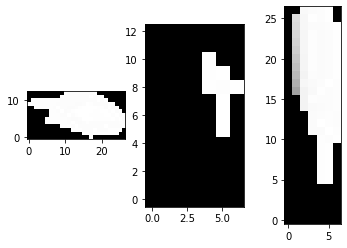

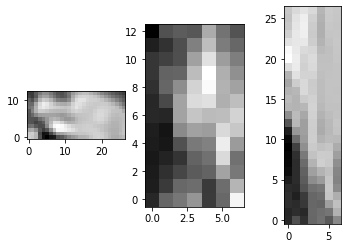

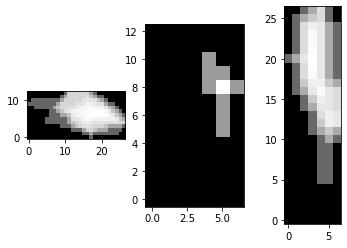

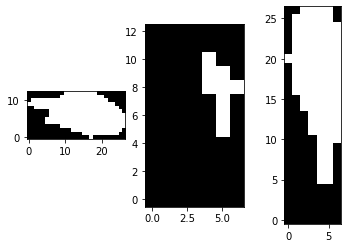

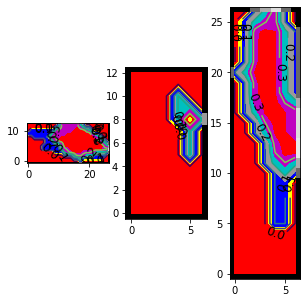

In [43]:
harm = recon_flair
sl_= 4
sx_ = 4
sy_ = 4

slice_0 = harm[sl_, :, :]
slice_1 = harm[:,sx_,:]
slice_2 = harm[:, :, sy_]

flair_0 = lesion_flair[sl_, :, :]
flair_1 = lesion_flair[:,sx_,:]
flair_2 = lesion_flair[:, :, sy_] 

edt_0 = edt[sl_, :, :]
edt_1 = edt[:,sx_,:]
edt_2 = edt[:, :, sy_]

gt_0 = gt[sl_, :, :]
gt_1 = gt[:,sx_,:]
gt_2 = gt[:, :, sy_]

dc_0 = dc[sl_, :, :]
dc_1 = dc[:,sx_,:]
dc_2 = dc[:, :, sy_]

c_0 = c_1[sl_, :, :]
c_11 = c_1[:,sx_,:]
c_2 = c_1[:, :, sy_]
'''
slice_0 = lesion_gado[4, :, :]
slice_1 = lesion_gado[:,6,:]
slice_2 = lesion_gado[:, :, 11]

gado_0 = recon_gado[4, :, :]
gado_1 = recon_gado[:,6,:]
gado_2 = recon_gado[:, :, 11]
'''
show_slices([slice_0, slice_1, slice_2], 'gray')
show_slices([flair_0, flair_1, flair_2], 'gray')
show_slices([edt_0, edt_1, edt_2], 'gray')
show_slices([gt_0, gt_1, gt_2], 'gray')
contour_slices([edt_0, edt_1, edt_2], 'gray')

NameError: name 'cmap' is not defined

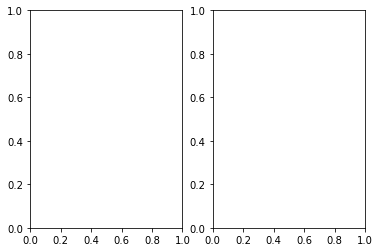

In [44]:
fig, axes = plt.subplots(1, 2)
slices = [flair_0[75:175, 0:60], edt_0[75:175, 0:60]]
for i, slice in enumerate(slices):
    im = axes[i].imshow(slice.T, cmap=cmap, origin="lower")
        
plt.show()

In [ ]:
slice = edt_0[75:175, 0:60]
row, col = np.shape(slice)
y = np.arange(0, row)
x = np.arange(0, col)
xx, yy = np.meshgrid(x, y)
cmap='gray'
contour_levels = 6
zzmin, zzmax = np.min(slice), np.max(slice)
levels = np.linspace(zzmin, zzmax, contour_levels)

fig, axes = plt.subplots(1,1, figsize=(20,20))
#Display image with contour plot
i=0
im = axes.imshow(slice.T, cmap=cmap, origin="lower")
contour = axes.contour(yy, xx, slice, levels)
axes.clabel(contour, colors = 'k', fmt = '%2.1f', fontsize=12)
c = ('#ff0000', '#ffff00', '#0000FF', '0.6', 'c', 'm')
contour_filled = axes.contourf(yy, xx, slice, colors=c)
plt.colorbar(contour_filled)

plt.show()

In [ ]:
edt_0[127,26]

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet

rgr_ridge = Ridge(alpha=0.3, max_iter=10000)
rgr_ridge.fit(array_basis, b)
coeff = rgr_ridge.coef_
intercepts = rgr_ridge.intercept_

tmp = array_basis @ coeff.T + intercepts
recon_flair = tmp.reshape((sl, x, y))

In [ ]:
harm = recon_flair
sl_= 3
sx_ = 4
sy_ = 4



slice_0 = harm[sl_, :, :]
slice_1 = harm[:,sx_,:]
slice_2 = harm[:, :, sy_]

flair_0 = lesion_flair[sl_, :, :]
flair_1 = lesion_flair[:,sx_,:]
flair_2 = lesion_flair[:, :, sy_] 

edt_0 = edt[sl_, :, :]
edt_1 = edt[:,sx_,:]
edt_2 = edt[:, :, sy_]

gt_0 = gt[sl_, :, :]
gt_1 = gt[:,sx_,:]
gt_2 = gt[:, :, sy_]

dc_0 = dc[sl_, :, :]
dc_1 = dc[:,sx_,:]
dc_2 = dc[:, :, sy_]

c_0 = c_1[sl_, :, :]
c_11 = c_1[:,sx_,:]
c_2 = c_1[:, :, sy_]
'''
slice_0 = lesion_gado[4, :, :]
slice_1 = lesion_gado[:,6,:]
slice_2 = lesion_gado[:, :, 11]

gado_0 = recon_gado[4, :, :]
gado_1 = recon_gado[:,6,:]
gado_2 = recon_gado[:, :, 11]
'''
show_slices([slice_0, slice_1, slice_2], 'gray')
show_slices([flair_0, flair_1, flair_2], 'gray')
show_slices([edt_0, edt_1, edt_2], 'gray')
show_slices([gt_0, gt_1, gt_2], 'gray')
contour_slices([edt_0, edt_1, edt_2], 'gray')

In [ ]:
# Get the isocontours.
# Source --> https://stackoverflow.com/questions/6030098/how-to-display-a-3d-plot-of-a-3d-array-isosurface-in-matplotlib-mplot3d-or-simil/35472146
edt = dict_dist[3]["edt"] 
level = 1.0
verts, faces, normals, values = measure.marching_cubes(edt)
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(verts[:, 0], verts[:,1], faces, verts[:, 2],
                cmap='Spectral', lw=1)
plt.show()


In [ ]:
# Display resulting triangular mesh using Matplotlib. This can also be done
# with mayavi (see skimage.measure.marching_cubes_lewiner docstring).
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')

# Fancy indexing: `verts[faces]` to generate a collection of triangles
mesh = Poly3DCollection(verts[faces])
mesh.set_edgecolor('g')
ax.add_collection3d(mesh)

ax.set_xlabel("x-axis: a = 6 per ellipsoid")
ax.set_ylabel("y-axis: b = 10")
ax.set_zlabel("z-axis: c = 16")

ax.set_xlim(0, 364)  # a = 6 (times two for 2nd ellipsoid)
ax.set_ylim(0, 427)  # b = 10
ax.set_zlim(0, 437)  # c = 16

plt.tight_layout()
plt.show()

In [ ]:
# Getting coordinates of each face
coord = verts[faces]

In [ ]:
np.max(array_basis)